## Evaluation

In [1]:
import json

with open("dataset/rag_truth_test.json", "r") as f:
    test_data = json.load(f)


In [2]:
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement whether it includes hallucination or not (based on the references above): " + d["text"]
    return data


dev_data = add_prefix(test_data)
dev_data[0]



{'ref': 'The FBI charged a Philadelphia woman on Thursday with trying to travel overseas to fight for ISIS. She\'s one of three women arrested this week on terror charges. Two New York women were also taken into custody. An FBI complaint cites numerous social media messages dating back to August 2013 that were sent by Keonna Thomas, 30, also known as "Young Lioness" and "Fatayat Al Khilafah." One Twitter message said, "If we truly knew the realities ... we all would be rushing to join our brothers in the front lines pray ALLAH accept us as shuhada [martyrs]." Another said, "When you\'re a mujahid [violent jihadi fighter] your death becomes a wedding." The FBI said Thomas purchased an electronic visa to Turkey on March 23. Turkey is known as the easiest place from which to enter Syria and join ISIS. An ISIS manual advises recruits to buy round-trip tickets to vacation spots such as Spain and then purchase tickets for their real destination once they arrive overseas, the FBI said. On Mar

In [3]:
# task_type: QA, Data2txt, Summary
task_name = "Summary"
test_data = [d for d in test_data if d["task_type"] == task_name]

In [4]:
from datasets import Dataset, DatasetDict
import pandas as pd


test_df = pd.DataFrame(test_data)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"test":test_ds})
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 900
    })
})

### no_doc

In [ ]:
from transformers import AutoModel, AutoTokenizer
from models_rob import NoDocModel

base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
# load trained model
name = "./trained/no_doc_rob"
model = NoDocModel.from_pretrained(base_model,name)
tokenizer = AutoTokenizer.from_pretrained(name)


In [6]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [7]:
from transformers import DataCollatorWithPadding

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [8]:
tokenized_datasets

DatasetDict({
    test: Dataset({
        features: ['ref', 'labels', 'source', 'model', 'task_type', 'source_id', 'input_ids', 'attention_mask'],
        num_rows: 900
    })
})

In [9]:
results = []
for i, d in enumerate(tokenized_datasets["test"]):
    results.append({"id": i,"label":d["labels"],"task":d["task_type"]})

results[0]

{'id': 0, 'label': 0, 'task': 'Summary'}

In [12]:
# inference
import torch
from tqdm import tqdm

model.eval()

for i,d in tqdm(enumerate(tokenized_datasets["test"])):
    input_ids =torch.tensor(d["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(d["attention_mask"]).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        predicted_index = torch.argmax(logits, dim=-1) # predicted label
    results[i]["no_rag_logits"] = logits.cpu().numpy()
    results[i]["no_rag_label"] = predicted_index.cpu().numpy()

2700it [00:13, 199.15it/s]


### with_doc

In [ ]:
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import torch
from models_rob import WithDocModel

base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")

name = "./trained/with_doc_rob"
model = WithDocModel.from_pretrained(base_model,name)
tokenizer = AutoTokenizer.from_pretrained(name)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


def tokenize_function(examples):
    ref = tokenizer(examples["ref"],truncation=True, max_length=512)
    text = tokenizer(examples["text"],truncation=True, max_length=512)
    return {
        "ref_input_ids":ref["input_ids"],
        "ref_attention_mask":ref["attention_mask"],
        "text_input_ids":text["input_ids"],
        "text_attention_mask":text["attention_mask"],
    }

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text","ref"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
import torch
from tqdm import tqdm

model.eval()

for i,d in tqdm(enumerate(tokenized_datasets["test"])):
    ref_input_ids = torch.tensor(d["ref_input_ids"]).unsqueeze(0).to(device)
    text_input_ids = torch.tensor(d["text_input_ids"]).unsqueeze(0).to(device)
    input_ids = [ref_input_ids, text_input_ids]
    
    ref_attention_mask = torch.tensor(d["ref_attention_mask"]).unsqueeze(0).to(device)
    text_attention_mask = torch.tensor(d["text_attention_mask"]).unsqueeze(0).to(device)
    attention_mask = [ref_attention_mask, text_attention_mask]
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        predicted_index = torch.argmax(logits, dim=-1)
        
    results[i]["rag_logits"] = logits.cpu().numpy()
    results[i]["rag_label"] = predicted_index.cpu().numpy()
        

2700it [00:32, 84.11it/s] 


### triplet

In [10]:
# triplet loss is not calculated during inference, so the other data is dummy ("hallucination"/"not hallucination")

def create_trip_ver2(data):
    trip = []
    for d in data:
        if d["labels"] == 0: # not hallucination
            trip.append({"anchor":d["ref"],"positive": d["text"], "negative": "hallucination", "labels": 0})
        else:
            trip.append({"anchor":d["ref"],"positive": "not hallucination", "negative": d["text"], "labels": 1})
    return trip

In [11]:
from datasets import Dataset, DatasetDict
import pandas as pd

test_trip = create_trip_ver2(test_data)

test_df = pd.DataFrame(test_trip)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"test":test_ds})
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 900
    })
})

In [12]:
import torch.nn.functional as F
import torch
import torch.nn as nn

def triplet_loss(anchor_output, positive_output, negative_output, positive_logits, negative_logits):
    positive_targets = torch.zeros(positive_output.size(0), dtype=torch.long).to(device)  # not hallucination
    negative_targets = torch.ones(negative_output.size(0), dtype=torch.long).to(device)
    positive_loss = nn.CrossEntropyLoss()(positive_logits, positive_targets)
    negative_loss = nn.CrossEntropyLoss()(negative_logits, negative_targets)

    classification_loss = (positive_loss + negative_loss) / 2.0

    triplet_loss_fn = (nn.TripletMarginWithDistanceLoss(margin=1.0,distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
    triplet_loss = triplet_loss_fn(anchor_output, positive_output, negative_output)

    return classification_loss, triplet_loss

In [ ]:
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import torch
from models_rob import TripletModel


base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")

name = "./trained/triplet_rob"
model = TripletModel.from_pretrained(base_model, triplet_loss, name)
tokenizer = AutoTokenizer.from_pretrained(name)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


def tokenize_function(examples):
    anchor = tokenizer(examples["anchor"], truncation=True,max_length=512)
    positive = tokenizer(examples["positive"], truncation=True,max_length=512)
    negative = tokenizer(examples["negative"], truncation=True,max_length=512)

    return {
        "anchor_input_ids": anchor["input_ids"],
        "anchor_attention_mask": anchor["attention_mask"],
        "positive_input_ids": positive["input_ids"],
        "positive_attention_mask": positive["attention_mask"],
        "negative_input_ids": negative["input_ids"],
        "negative_attention_mask": negative["attention_mask"],
    }


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["anchor", "positive", "negative"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
import torch
from tqdm import tqdm

model.eval()

for i,d in tqdm(enumerate(tokenized_datasets["test"])):
    
    flag = False # hallusination → True
    if d["labels"] == 1:
        flag = True
    
    anchor_input_ids = torch.tensor(d["anchor_input_ids"], dtype=torch.long).unsqueeze(0).to(device)
    positive_input_ids = torch.tensor(d["positive_input_ids"], dtype=torch.long).unsqueeze(0).to(device)
    negative_input_ids = torch.tensor(d["negative_input_ids"], dtype=torch.long).unsqueeze(0).to(device)
    input_ids = [anchor_input_ids, positive_input_ids, negative_input_ids]
    anchor_attention_mask = torch.tensor(d["anchor_attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
    positive_attention_mask = torch.tensor(d["positive_attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
    negative_attention_mask = torch.tensor(d["negative_attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
    attention_mask = [anchor_attention_mask, positive_attention_mask, negative_attention_mask]
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        if flag:
            logits = outputs.logits[1] # negative_logit
        else:
            logits = outputs.logits[0] # positive_logit
        predicted_index = torch.argmax(logits, dim=-1)
    results[i]["triplet_logits"] = logits.cpu().numpy()
    results[i]["triplet_label"] = predicted_index.cpu().numpy()
        

900it [00:13, 65.32it/s]


In [29]:
results[-1]

{'id': 2699,
 'label': 0,
 'task': 'QA',
 'no_rag_logits': array([[-0.47302994,  0.9884404 ]], dtype=float32),
 'no_rag_label': array([1]),
 'rag_logits': array([[0.34309223, 0.17094655]], dtype=float32),
 'rag_label': array([0]),
 'triplet_logits': array([[-1.6563241,  1.5209625]], dtype=float32),
 'triplet_label': array([1])}

In [30]:
# save results
import numpy as np
import json
for result in results:
    if isinstance(result["no_rag_logits"], np.ndarray):
        result["no_rag_logits"] = result["no_rag_logits"].tolist()
    if isinstance(result["rag_logits"], np.ndarray):
        result["rag_logits"] = result["rag_logits"].tolist()
    if isinstance(result["triplet_logits"], np.ndarray):
        result["triplet_logits"] = result["triplet_logits"].tolist()
    if isinstance(result["no_rag_label"], np.ndarray):
        result["no_rag_label"] = result["no_rag_label"].tolist()
    if isinstance(result["rag_label"], np.ndarray):
        result["rag_label"] = result["rag_label"].tolist()
    if isinstance(result["triplet_label"], np.ndarray):
        result["triplet_label"] = result["triplet_label"].tolist()



with open("check_improve_rob.json", "w") as f:
    json.dump(results, f)

## View results

In [15]:
import json

with open('check_improve_rob.json',"r") as f:
    results = json.load(f)


In [17]:
# compare no_doc and triplet

id_000 = [] # both success not to detect
id_001 = [] # both fail to detect
id_010 = [] # over-detect in triplet
id_011 = [] # success to detect only in triplet
id_100 = [] # success not to detect only i triplet
id_101 = [] # fail to detect only in triplet
id_110 = [] # both over-detect
id_111 = [] # both success to detect

for result in results:
    if result["no_rag_label"][0]==0 and result["triplet_label"][0]==0 and result["label"]==0:
        id_000.append(result["id"])
    elif result["no_rag_label"][0]==0 and result["triplet_label"][0]==0 and result["label"]==1:
        id_001.append(result["id"])
    elif result["no_rag_label"][0]==0 and result["triplet_label"][0]==1 and result["label"]==0:
        id_010.append(result["id"])
    elif result["no_rag_label"][0]==0 and result["triplet_label"][0]==1 and result["label"]==1:
        id_011.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==0 and result["label"]==0:
        id_100.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==0 and result["label"]==1:
        id_101.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==1 and result["label"]==0:
        id_110.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==1 and result["label"]==1:
        id_111.append(result["id"])    
    

print(len(id_000),len(id_001),len(id_010),len(id_011),len(id_100),len(id_101),len(id_110),len(id_111))
# 000:516, 001:53, 010:455, 011:88, 100:148, 101:49, 110:638, 111:753 ---rob

516 53 455 88 148 49 638 753


### embedding

In [18]:
import json

with open("dataset/rag_truth_test.json", "r") as f:
    test_data = json.load(f)
    
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement whether it includes hallucination or not based on the references above: " + d["text"]
    return data

test_data = add_prefix(test_data)

In [19]:
# task_type: QA, Data2txt, Summary
task_name = "Data2txt"
task = "d2t" # used for file name
test_data = [d for d in test_data if d["task_type"] == task_name]

In [20]:
import os
save_folder = "embedding"
os.makedirs(save_folder, exist_ok=True) 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from models_rob import NoDocModel

model_name = "FacebookAI/RoBERTa-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name) # before train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

texts = [x["text"] for x in test_data]

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs[1] 
    embeddings = embeddings.cpu().numpy()  

# dimensional reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

# plot
plt.figure(figsize=(8, 8))
for i, text in enumerate(texts):
    if test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "red",s = 30)
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#00DDFF",s = 30)
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "green",s = 30)

# change according to task

#plt.scatter([], [],color = "#000000", label = "QA (hal)",marker="^")
#plt.scatter([], [],color = "red", label = "QA (not hal)")
plt.scatter([], [],color = "#000000", label = "Data2txt (hal)",marker="^")
plt.scatter([], [],color = "#00DDFF", label = "Data2txt (not hal)")
#plt.scatter([], [],color = "#002100", label = "Summary (hal)",marker="^")
#plt.scatter([], [],color = "green", label = "Summary (not hal)")


plt.legend(fontsize="x-large")

file_path = os.path.join(save_folder, f"before_{task}.png")
plt.savefig(file_path, format="png", dpi=300) 
plt.show()
plt.close()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from models_rob import NoDocModel

model_name = "FacebookAI/RoBERTa-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)
model = NoDocModel.from_pretrained(base_model, "trained/no_doc_rob") 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

texts = [x["text"] for x in test_data]

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings =outputs.output 
    embeddings = embeddings.cpu().numpy() 

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

plt.figure(figsize=(8, 8))
for i, text in enumerate(texts):
    if test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "red",s = 30)
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#00DDFF",s = 30)
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "green",s = 30)

#plt.scatter([], [],color = "#000000", label = "QA (hal)",marker="^")
#plt.scatter([], [],color = "red", label = "QA (not hal)")
plt.scatter([], [],color = "#000000", label = "Data2txt (hal)",marker="^")
plt.scatter([], [],color = "#00DDFF", label = "Data2txt (not hal)")
#plt.scatter([], [],color = "#002100", label = "Summary (hal)",marker="^")
#plt.scatter([], [],color = "green", label = "Summary (not hal)")

plt.legend(fontsize="x-large")

file_path = os.path.join(save_folder, f"no_doc_{task}.png")
plt.savefig(file_path, format="png", dpi=300) 
plt.show()
plt.close()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from models_rob import WithDocModel


model_name = "FacebookAI/RoBERTa-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

model = WithDocModel.from_pretrained(base_model, "trained/with_doc_rob")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# data
refs = [x["ref"] for x in test_data]
texts = [x["text"] for x in test_data]
refs_tok = tokenizer(refs, padding=True, truncation=True, return_tensors="pt")
texts_tok = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

inputs = {
    "input_ids":[refs_tok["input_ids"].to(device),texts_tok["input_ids"].to(device)],
    "attention_mask":[refs_tok["attention_mask"].to(device),texts_tok["attention_mask"].to(device)]
}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings =outputs.output[1] 
    embeddings = embeddings.cpu().numpy()  

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

plt.figure(figsize=(8, 8))
for i, text in enumerate(texts):
    if test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "red",s = 30)
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#00DDFF",s = 30)
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "green",s = 30)

#plt.scatter([], [],color = "#000000", label = "QA (hal)",marker="^")
#plt.scatter([], [],color = "red", label = "QA (not hal)")
plt.scatter([], [],color = "#000000", label = "Data2txt (hal)",marker="^")
plt.scatter([], [],color = "#00DDFF", label = "Data2txt (not hal)")
#plt.scatter([], [],color = "#002100", label = "Summary (hal)",marker="^")
#plt.scatter([], [],color = "green", label = "Summary (not hal)")

plt.legend(fontsize="x-large")

file_path = os.path.join(save_folder, f"with_doc_{task}.png")
plt.savefig(file_path, format="png", dpi=300)
plt.show()
plt.close()


In [25]:
import torch.nn.functional as F
import torch
import torch.nn as nn

def triplet_loss(anchor_output, positive_output, negative_output, positive_logits, negative_logits):
    positive_targets = torch.zeros(positive_output.size(0), dtype=torch.long).to(device)  
    negative_targets = torch.ones(negative_output.size(0), dtype=torch.long).to(device)
    positive_loss = nn.CrossEntropyLoss()(positive_logits, positive_targets)
    negative_loss = nn.CrossEntropyLoss()(negative_logits, negative_targets)

    classification_loss = (positive_loss + negative_loss) / 2.0

    triplet_loss_fn = (nn.TripletMarginWithDistanceLoss(margin=1.0,distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
    triplet_loss = triplet_loss_fn(anchor_output, positive_output, negative_output)

    return classification_loss, triplet_loss

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from models_rob import TripletModel

model_name = "FacebookAI/RoBERTa-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

model = TripletModel.from_pretrained(base_model, triplet_loss,"trained/triplet_rob")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

refs = [x["ref"] for x in test_data]
posis = [x["text"] if x["labels"] == 0 else "sample" for x in test_data]
negas = [x["text"] if x["labels"] == 1 else "sample" for x in test_data]
labels = [x["labels"] for x in test_data]

refs_tok = tokenizer(refs, padding=True, truncation=True, return_tensors="pt")
posis_tok = tokenizer(posis, padding=True, truncation=True, return_tensors="pt")
negas_tok = tokenizer(negas, padding=True, truncation=True, return_tensors="pt")

inputs = {
    "input_ids":[refs_tok["input_ids"].to(device),posis_tok["input_ids"].to(device),negas_tok["input_ids"].to(device)],
    "attention_mask":[refs_tok["attention_mask"].to(device),posis_tok["attention_mask"].to(device),negas_tok["attention_mask"].to(device)],
    "labels":labels
}


with torch.no_grad():
    outputs = model(**inputs)
    embeddings =outputs.output[1] 
    embeddings = embeddings.cpu().numpy() 

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

plt.figure(figsize=(8, 8))
for i, text in enumerate(texts):
    if test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "red",s = 30)
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#00DDFF",s = 30)
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#000000",s = 30,marker="^")
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "green",s = 30)

#plt.scatter([], [],color = "#000000", label = "QA (hal)",marker="^")
#plt.scatter([], [],color = "red", label = "QA (not hal)")
plt.scatter([], [],color = "#000000", label = "Data2txt (hal)",marker="^")
plt.scatter([], [],color = "#00DDFF", label = "Data2txt (not hal)")
#plt.scatter([], [],color = "#002100", label = "Summary (hal)",marker="^")
#plt.scatter([], [],color = "green", label = "Summary (not hal)")

plt.legend(fontsize="x-large")

file_path = os.path.join(save_folder, f"triplet_{task}.png")
plt.savefig(file_path, format="png", dpi=300) 
plt.show()
plt.close()


### Similarity (between document and text)

In [ ]:
%pip install transformers==4.44.0
%pip show transformers

In [27]:
import json

with open("dataset/rag_truth_span_test.json", "r") as f:
    test_data_span = json.load(f)

In [28]:
import torch.nn.functional as F
import torch
import torch.nn as nn

def triplet_loss(anchor_output, positive_output, negative_output, positive_logits, negative_logits):
    positive_targets = torch.zeros(positive_output.size(0), dtype=torch.long).to(device)  
    negative_targets = torch.ones(negative_output.size(0), dtype=torch.long).to(device)
    positive_loss = nn.CrossEntropyLoss()(positive_logits, positive_targets)
    negative_loss = nn.CrossEntropyLoss()(negative_logits, negative_targets)

    classification_loss = (positive_loss + negative_loss) / 2.0

    triplet_loss_fn = (nn.TripletMarginWithDistanceLoss(margin=1.0,distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
    triplet_loss = triplet_loss_fn(anchor_output, positive_output, negative_output)

    return classification_loss, triplet_loss

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
from models_rob import NoDocModel, WithDocModel, TripletModel

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/RoBERTa-base")
base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")

no_doc_model = NoDocModel.from_pretrained(base_model,"trained/no_doc_rob")
with_doc_model = WithDocModel.from_pretrained(base_model,"trained/with_doc_rob")
triplet_model = TripletModel.from_pretrained(base_model,triplet_loss, "trained/triplet_rob")

def calc_sim_before(ref, text):
    ref_tokens = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tokens = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    
    with torch.no_grad():  
        ref_output = base_model(**ref_tokens)
        text_output = base_model(**text_tokens)

    ref_embedding = ref_output.last_hidden_state.mean(dim=1).detach().numpy()
    text_embedding = text_output.last_hidden_state.mean(dim=1).detach().numpy()
    
    return cosine_similarity(ref_embedding, text_embedding)[0][0]

def calc_sim_no_doc(ref, text):
    ref_tokens = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tokens = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    
    with torch.no_grad():  
        ref_output = no_doc_model(**ref_tokens)
        text_output = no_doc_model(**text_tokens)

    ref_embedding = ref_output.output.cpu().numpy()
    text_embedding = text_output.output.cpu().numpy()
    
    return cosine_similarity(ref_embedding, text_embedding)[0][0]

def calc_sim_with_doc(ref, text):
    ref_tok = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tok = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    
    inputs = {
    "input_ids":[ref_tok["input_ids"],text_tok["input_ids"]],
    "attention_mask":[ref_tok["attention_mask"],text_tok["attention_mask"]]
    }   
 
    with torch.no_grad(): 
        output = with_doc_model(**inputs)

    ref_output = output.output[0].cpu().numpy()
    text_output = output.output[1].cpu().numpy()

    return cosine_similarity(ref_output, text_output)[0][0]

def calc_sim_triplet(ref, text, label):
    ref_tok = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tok = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    sample_tok = tokenizer("sample", padding="longest", truncation=True, return_tensors="pt")
    
    if label[0] == 1: # hallucination / negative
        inputs = {
        "input_ids":[ref_tok["input_ids"],sample_tok["input_ids"],text_tok["input_ids"]],
        "attention_mask":[ref_tok["attention_mask"],sample_tok["attention_mask"],text_tok["attention_mask"]],
        "labels": label
        }   
    elif label[0] == 0: # not hallucination / positive
        inputs = {
        "input_ids":[ref_tok["input_ids"],text_tok["input_ids"], sample_tok["input_ids"]],
        "attention_mask":[ref_tok["attention_mask"],text_tok["attention_mask"], sample_tok["attention_mask"]],
        "labels": label
        }

    with torch.no_grad(): 
        output = triplet_model(**inputs)
    ref_output = output.output[0].cpu().numpy()
    text_output = output.output[1].cpu().numpy()

    return cosine_similarity(ref_output, text_output)[0][0]

In [ ]:
from tqdm import tqdm

for d in tqdm(test_data_span):
    sim_before = calc_sim_before(d["ref"], d["text"])
    sim_no_doc = calc_sim_no_doc(d["ref"], d["text"])
    sim_with_doc = calc_sim_with_doc(d["ref"], d["text"])
    sim_triplet = calc_sim_triplet(d["ref"], d["text"], [d["labels"]])
    
    d["sim_before"] = sim_before
    d["sim_no_doc"] = sim_no_doc
    d["sim_doc"] = sim_with_doc
    d["sim_triplet"] = sim_triplet


In [ ]:
test_data_span[10]

In [ ]:
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# write json
with open("dataset/rag_truth_span_test_sim.json", "w") as f:
    json.dump(test_data_span, f, cls=NumpyEncoder, ensure_ascii=False, indent=4)

In [35]:
with open("dataset/rag_truth_span_test_sim.json", "r") as f:
    test_data_span = json.load(f)

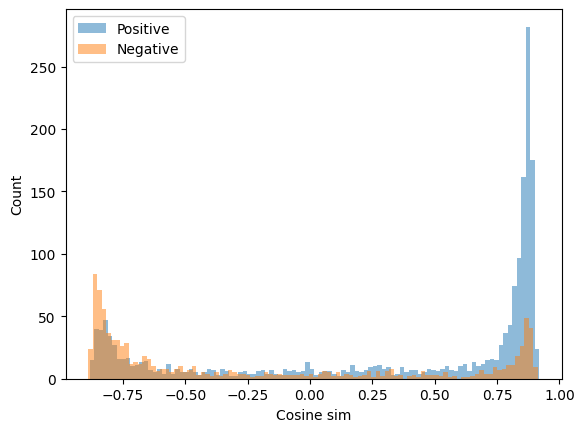

In [37]:
import matplotlib.pyplot as plt
import numpy as np

before_posi = []
before_nega = []

id_all = id_000 + id_001 + id_010 + id_011 + id_100 + id_101 + id_110 + id_111
id_tri_fail = id_001 + id_010 + id_101 + id_110
id_tri_suc = id_000 + id_011 + id_100 + id_111

# mode: sim_before, sim_no_doc, sim_doc, sim_triplet
mode = "triplet" # if you use the file you made, change "triplet" to "sim_triplet"

for i in id_all :
    d = test_data_span[i]
    
    if d["labels"] == 1:
        before_nega.append(d[mode])
    else:
        before_posi.append(d[mode])
        
plt.hist(before_posi, bins=100, alpha=0.5, label="Positive")
plt.hist(before_nega, bins=100, alpha=0.5, label="Negative")
plt.xlabel("Cosine sim")
plt.ylabel("Count")


plt.legend()
plt.show()


